In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="phyllochron_DVI"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git"),
    ("do3se_phenology", "github.com/SEI-DO3SE/do3se_phenology.git"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
    ("notebook_utils", "github.com/sbland/notebook_utils.git"),
]

In [3]:
# Create colab link
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/master/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/master/notebooks/phyllochron_DVI.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except (ImportError, ModuleNotFoundError):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            !pip install git+https://{user}:{token}@{path}
        creds.close()
        creds = None
        creds_parsed = None

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate
import numpy as np
from functools import partial
from notebook_utils import *
from _utils import interact_plus_reset
import ipywidgets as widgets

In [6]:
%load_ext autoreload
%autoreload 2

from do3se_phenology.phyllochron_dvi import *


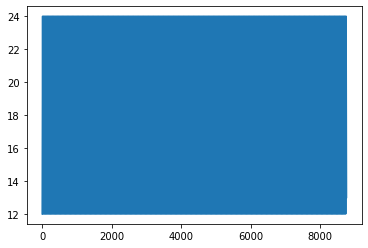

In [7]:
# Demo data
day_count = 365
lat = 20
demo_temp_data = [18 for _ in range(1253)]
accumulated_temperatures = list(accumulate(demo_temp_data))
dd_data = np.array([[d for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
hrs_data = np.array([[i for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
demo_temp_data = [24-abs(hr-12) for hr in hrs_data]
demo_temp_data[0:30]
plt.plot(demo_temp_data)
 


In [8]:
from do3se_met.irradiance import *
from thermal_time.calcs import *

In [9]:
# Calc thermal time
T_b, T_o, T_m = [0,20,50]
lat = 50
p_crit=24
p_sens=0
tsc = demo_temp_data
td = calc_thermal_time_range(tsc, T_b)
teff = [calc_effective_temperature(tsc[d*24:(d+1)*24],T_b, T_o, T_m) for d in dd_data]

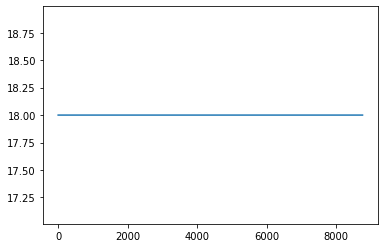

In [10]:
plt.plot(teff)

In [11]:
photoperiod = [calc_photoperiod(dd, lat) for dd in dd_data]
rpe = [calc_rpe(p_crit=p_crit, p_sens=p_sens, p=P) for P in photoperiod]

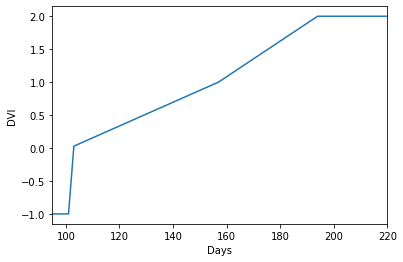

366

In [12]:

dvi = [-1]
tt_emr, tt_veg, tt_rep = [35, 1000, 666]
sowing_day = 100
for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
  if hr == 0:
    new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
    dvi.append(new_dvi)
plt.xlim(sowing_day - 5, sowing_day+120)
plt.plot(dvi)
plt.xlabel("Days")
plt.ylabel("DVI")
plt.show()
len(dvi)

In [13]:
emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])


In [18]:
#@title Life stage from td_data
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  sowing_day = widgets.FloatSlider(min=1, max=365, value=100, step=1),   
)
def run(tt_emr, tt_veg, tt_rep, sowing_day):
  dvi = [-1]
  for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
    if hr == 0:
      new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
      dvi.append(new_dvi)
  plt.xlim(sowing_day - 5, sowing_day+120)
  plt.plot(dvi)
  plt.xlabel("Days")
  plt.ylabel("DVI")

  emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
  phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])
  life_stages = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=0.3)
  life_stages
  plt.show()


Button(description='Reset', style=ButtonStyle())

Output()

In [19]:
t_lse_constant=0.3
calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=t_lse_constant)

output(t_l=509.61538461538464, t_lem=173.0769230769231, t_lep=235.5769230769231, t_lse=100.96153846153847, t_lma=336.53846153846155)

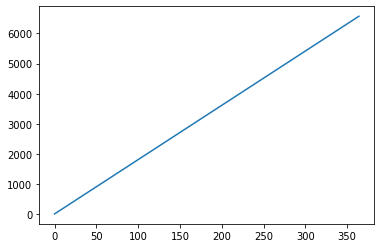

In [20]:
td_daily = [td for td, hr in zip(td, hrs_data) if hr == 0]
plt.plot(td_daily)

In [22]:
#@title leaf_f_phen
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  t_astart=widgets.FloatSlider(min=1, max=2000, value=950, step=1),
  td_at_sgs=widgets.FloatSlider(min=1, max=2000, value=100, step=1),
)
def get_t_l(
    tt_emr, tt_veg, tt_rep,
    t_astart,
    td_at_sgs,
):
    # DVI
    fig, axs = plt.subplots(ncols=2, figsize=(24,8))
    dvi = [-1]
    for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
        if hr == 0:
            new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
            dvi.append(new_dvi)
    

    axs[0].plot(td_daily, dvi[1:])
    axs[0].set_xlabel("Days")
    axs[0].set_ylabel("DVI")

    # t_l
    t_lse_constant=0.3
    LS = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=t_lse_constant)
    td_dd_list = [t - t_astart - td_at_sgs for t in td]
    f_LA = [max(0,min(1,1 - (td_dd - LS.t_lem) / (LS.t_lma))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0,min(1,1 - ((td_dd - LS.t_lem - LS.t_lep) / (LS.t_lma / fO3_l - LS.t_lep)))) for td_dd in td_dd_list]

    axs[1].plot(td, f_LA, label="f_LA")
    axs[1].plot(td, f_LS, label="f_LS")
    axs[1].axvline(td_at_sgs + t_astart + LS.t_l, linestyle='dotted', color="red")
    axs[1].text(td_at_sgs + t_astart + LS.t_l, 0.5, 't_l', rotation=45, color="red")
    axs[1].axvline(td_at_sgs + t_astart, linestyle='dotted', color="green")
    axs[1].text(td_at_sgs + t_astart, 0.5, 't_Astart', rotation=45, color="green")

    plt.legend()

    # DVI
    plt.show()

Button(description='Reset', style=ButtonStyle())

Output()